In [1]:
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt

In [4]:
def correlation_matern(rho, rho0, nu=2.5):                                                                                                                                                                                                                                                                             
    rho1 = np.sqrt(2 * nu) * np.abs(rho) / rho0                                                                                                             

    zero_indices = np.where(rho1 == 0)[0]                                                                                                                                   

    c = (rho1 ** nu 
         * sp.special.kv(nu, rho1) 
         / sp.special.gamma(nu) 
         / 2.0 ** (nu - 1))                                                                              
    c[zero_indices] = 1.0
    
    return c

In [5]:
def correlation_exp(rho, rho0, dummy):
    c = np.exp(-np.abs(rho/rho0))
    return c

In [6]:
def correlation_sqd_exp(rho, rho0, dummy):
    c = np.exp(-(rho**2 / (2 * rho0**2)))
    return c

In [99]:
def make_correlation_matrix(rho, rho0, correlation, nu=None):                                                                                                                                                                                                                                                               
    Nx = rho.size                                                                                                                                              
    cor_vec = correlation(rho, rho0, nu)                                                                                                                                                                                                                                                                        
    C = np.zeros([Nx, Nx])                                                                                                                                                                                                                                                                                          
    cor_vec = np.concatenate([cor_vec[:0:-1], cor_vec])                                                                                                                                                                                          
    for i in range(Nx):
        C[i] = cor_vec[Nx-1 - i:2 * Nx - 1 - i]
    return C

# Check matern against exp

In [162]:
rho = np.arange(10)
rho0 = 10
nu = .5

In [163]:
print(nu)
correlation_matern(rho, rho0, nu)

0.5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


array([1.        , 0.90483742, 0.81873075, 0.74081822, 0.67032005,
       0.60653066, 0.54881164, 0.4965853 , 0.44932896, 0.40656966])

In [164]:
correlation_exp(rho, rho0, nu)

array([1.        , 0.90483742, 0.81873075, 0.74081822, 0.67032005,
       0.60653066, 0.54881164, 0.4965853 , 0.44932896, 0.40656966])

# Check matern agains sqd exp

In [10]:
rho = np.arange(10)
rho0 = 10
nu = 150

In [11]:
print(nu)
correlation_matern(rho, rho0, nu)

150


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


array([1.        , 0.99497918, 0.98006845, 0.95571542, 0.92264105,
       0.88180398, 0.83435417, 0.78157885, 0.72484455, 0.66553864])

In [12]:
correlation_sqd_exp(rho, rho0, nu)

array([1.        , 0.99501248, 0.98019867, 0.95599748, 0.92311635,
       0.8824969 , 0.83527021, 0.78270454, 0.72614904, 0.66697681])

# Correlation matrix for a ring

Text(0.5,1,'Covariance matrix for a ring')

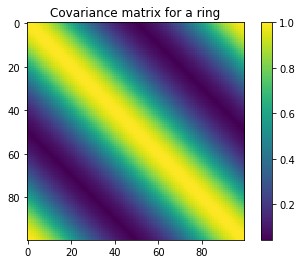

In [137]:
n = 100
rho0 = 20
rho = np.arange(n, dtype=float)
rho = np.minimum(rho % n, (n - rho) % n)

P = make_correlation_matrix(rho, rho0, correlation_sqd_exp)

plt.figure()
im = plt.imshow(P)
plt.colorbar(im)
plt.title('Covariance matrix for a ring')

In [101]:
D, E = sp.linalg.eigh(P)
D = D.clip(min=0)
D = D[::-1]
E = E[:, ::-1]

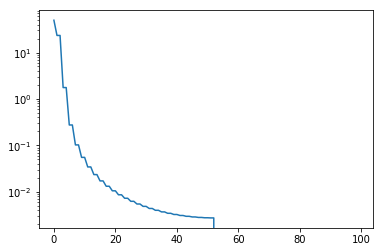

In [102]:
plt.figure()
plt.semilogy(D)

In [103]:
sqrtP = E @ np.diag(np.sqrt(D)) @ E.T

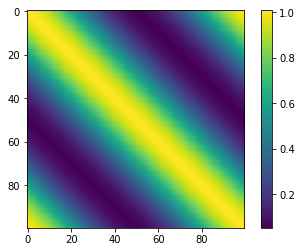

In [104]:
plt.figure()
im = plt.imshow(sqrtP@sqrtP)
plt.colorbar(im)


# Check ensemble est. of covariance

In [182]:
n = 100
Ne = 10000
rho0 = 0.1
Nrealizations = 200
NeigSubspace = 5
nu = 3/2
rho = np.arange(n)/n

P = make_correlation_matrix(rho, rho0, correlation_matern, nu=nu)

D, E = sp.linalg.eigh(P)
D = D.clip(min=0)
D = D[::-1]
E = E[:, ::-1]
sqrt_P = E @ np.sqrt(P) @ E.T
E_save = np.zeros([n, NeigSubspace, Nrealizations])
D_save = np.zeros([NeigSubspace, Nrealizations])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [183]:
NeigSubspace

5

In [184]:
for ii in range(Nrealizations):
    X = sqrt_P @ np.random.randn(n, Ne)
    X = X - np.repeat(X.mean(axis=1)[:, None], Ne, axis=1)
    X = X / np.sqrt(Ne - 1)
    P_hat = X @ X.T
    D_save[:, ii], E_save[:, :, ii] = sp.linalg.eigh(
        P_hat, eigvals=((n - NeigSubspace), n - 1))

In [185]:
max_lambda = np.zeros([Nrealizations, Nrealizations])
min_lambda = max_lambda.copy()
sum_lambda = max_lambda.copy()
for ii in range(Nrealizations):
    for jj in range(Nrealizations):
        IPs = E_save[:, :, ii].T @ E_save[:, :, jj]
        Lambda = sp.linalg.svd(IPs, compute_uv=False)
        max_lambda[ii, jj] = Lambda.max()
        min_lambda[ii, jj] = Lambda.min()
        sum_lambda[ii, jj] = (Lambda**2).sum()

Text(0.5,1,'sum lambda; mean: 5.0')

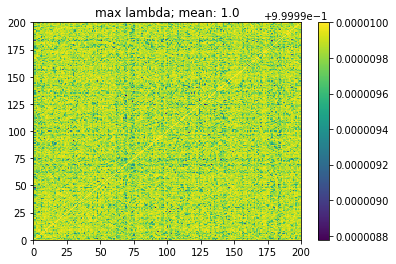

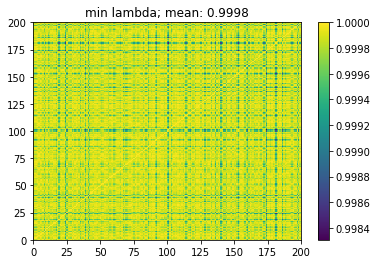

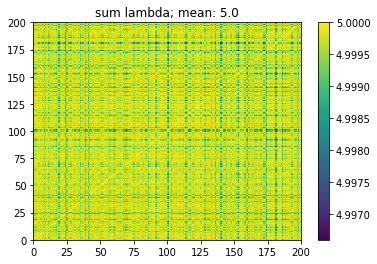

In [190]:
this = max_lambda.mean()
plt.figure()
im = plt.pcolormesh(max_lambda)
plt.colorbar(im)
plt.title(f'max lambda; mean: {this:0.4}')

this = min_lambda.mean()
plt.figure()
im = plt.pcolormesh(min_lambda)
plt.colorbar(im)
plt.title(f'min lambda; mean: {this:0.4}')

this = sum_lambda.mean()
plt.figure()
im = plt.pcolormesh(sum_lambda)
plt.colorbar(im)
plt.title(f'sum lambda; mean: {this:0.4}')